# Downstream Transportation Principal Component Analysis (PCA) and Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error)
from sklearn.preprocessing import PowerTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from IPython.display import display

# Import downstream_transport dataframe
downstream_transport=pd.read_csv('downstream_transport.csv')

In [2]:
downstream_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                2481 non-null   object 
 1   account_id                  2481 non-null   int64  
 2   Year                        2481 non-null   int64  
 3   incorporated_country        2481 non-null   object 
 4   Primary activity            2481 non-null   object 
 5   Primary sector              2481 non-null   object 
 6   Market_Cap_USD              1999 non-null   float64
 7   Third_party_verification    2481 non-null   object 
 8   Revenue_USD                 2015 non-null   float64
 9   ebitda_USD                  2015 non-null   float64
 10  grossProfit_USD             2015 non-null   float64
 11  netIncome_USD               2015 non-null   float64
 12  cashAndCashEquivalents_USD  2015 non-null   float64
 13  shortTermInvestments_USD    2015 

In [3]:
downstream_transport.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,Antofagasta,820,2018,United Kingdom,Other non-ferrous ore mining,Metallic mineral mining,7.721230e+09,Third-party verification or assurance process ...,4.733100e+09,2.092800e+09,...,1.060800e+09,1.410250e+10,4.664400e+09,1.924000e+09,2.493900e+09,9.438100e+09,Downstream transportation and distribution,2796.0,3.292186e+06,4072324
1,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,9.900000e+07,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,Downstream transportation and distribution,237690.0,3.804718e+05,4072324
2,AstraZeneca,1104,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.441091e+10,Third-party verification or assurance process ...,2.209000e+10,7.165000e+09,...,1.130000e+08,6.065100e+10,4.660700e+10,9.220000e+08,1.911300e+10,1.404400e+10,Downstream transportation and distribution,318080.0,7.072529e+05,4072324
3,Britvic,2280,2018,United Kingdom,Non-alcoholic beverages,Food & beverage processing,2.702902e+09,Third-party verification or assurance process ...,1.909572e+09,2.719070e+08,...,5.118100e+07,2.235708e+09,1.756537e+09,9.728200e+07,9.767570e+08,4.791710e+08,Downstream transportation and distribution,54149.0,4.579525e+04,4072324
4,Bunzl plc,2412,2018,United Kingdom,"Dealers, wholesalers & distributors","Trading, wholesale, distribution, rental & lea...",1.007031e+10,No third-party verification or assurance,1.153084e+10,8.074660e+08,...,7.493000e+06,7.056247e+09,4.904232e+09,7.493000e+06,2.368169e+09,2.152015e+09,Downstream transportation and distribution,78724.0,1.076858e+05,4072324


In [4]:
# Rename features
downstream_transport = downstream_transport.rename(columns={'incorporated_country': 'Countries',
                                          'Primary activity': 'Primary_activity',
                                          'Primary sector': 'Primary_sector'})

# Drop unneeded columns
downstream_transport = downstream_transport.drop(
    ['Third_party_verification', 'Scope_3_emissions_type'], axis=1, errors='ignore')

downstream_transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                2481 non-null   object 
 1   account_id                  2481 non-null   int64  
 2   Year                        2481 non-null   int64  
 3   Countries                   2481 non-null   object 
 4   Primary_activity            2481 non-null   object 
 5   Primary_sector              2481 non-null   object 
 6   Market_Cap_USD              1999 non-null   float64
 7   Revenue_USD                 2015 non-null   float64
 8   ebitda_USD                  2015 non-null   float64
 9   grossProfit_USD             2015 non-null   float64
 10  netIncome_USD               2015 non-null   float64
 11  cashAndCashEquivalents_USD  2015 non-null   float64
 12  shortTermInvestments_USD    2015 non-null   float64
 13  longTermInvestments_USD     2015 

In [5]:
# Looking at missing data
print(downstream_transport.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                19.4
cashAndCashEquivalents_USD    18.8
totalLiabilities_USD          18.8
totalEquity_USD               18.8
totalDebt_USD                 18.8
Revenue_USD                   18.8
ebitda_USD                    18.8
grossProfit_USD               18.8
netIncome_USD                 18.8
totalInvestments_USD          18.8
shortTermInvestments_USD      18.8
longTermInvestments_USD       18.8
totalAssets_USD               18.8
scope_1_2_emissions_amount     0.1
Scope_3_emissions_amount       0.0
account_name                   0.0
account_id                     0.0
Primary_sector                 0.0
Primary_activity               0.0
Countries                      0.0
Year                           0.0
Year_sq                        0.0
dtype: float64


### Principal Component Analysis (PCA) for Downstream Transport

- Selects numeric columns (excluding IDs, categorical, and target columns) from the `downstream_transport` dataset.
- Applies a signed log transformation to normalize and stabilize the data.
- Drops rows with missing values for robust PCA input.
- Standardizes the transformed data before fitting PCA.
- Fits PCA and creates principal component columns (`PC1`, `PC2`, ...) for all valid rows.
- Appends the new principal component features back to the original dataframe.
- Visualizes the explained variance for each component (scree plot and cumulative plot).
- Prints the cumulative variance explained by each principal component.

_Result:_  
`downstream_transport_with_pcs` contains appended principal components for downstream modeling and analysis.

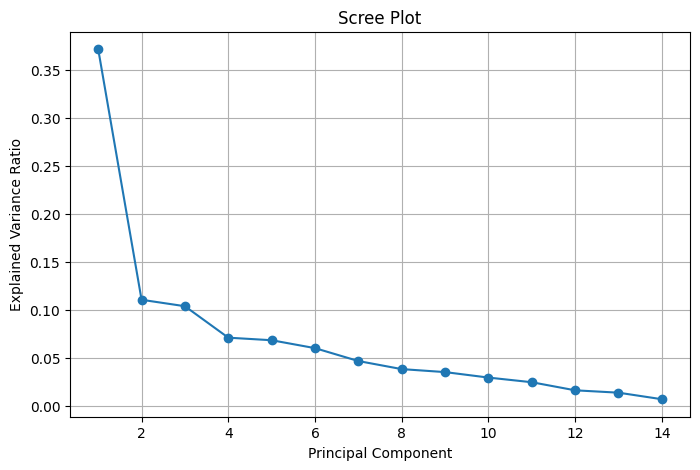

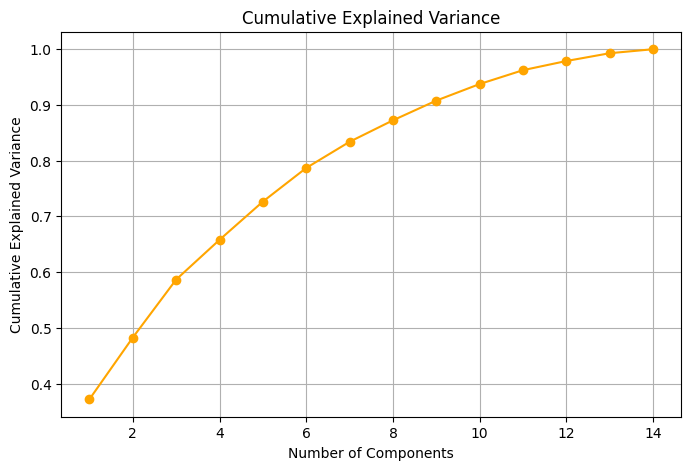

Cumulative variance explained by each additional principal component:
  PC1: 0.3718
  PC2: 0.4826
  PC3: 0.5866
  PC4: 0.6579
  PC5: 0.7265
  PC6: 0.7869
  PC7: 0.8339
  PC8: 0.8724
  PC9: 0.9078
  PC10: 0.9375
  PC11: 0.9624
  PC12: 0.9789
  PC13: 0.9928
  PC14: 1.0000


In [6]:
# --- STEP 1: Select appropriate columns for PCA ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in downstream_transport.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(downstream_transport[col])
    and col != "Scope_3_emissions_amount"
]
X = downstream_transport[numeric_cols].copy()

# --- STEP 2: Apply sign-log transformation ---
def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)

# --- STEP 3: Drop rows with missing values (keep track of indices) ---
X_dropped = X_transformed.dropna()
pca_indices = X_dropped.index

# --- STEP 4: Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

# --- STEP 5: Fit PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- STEP 6: Create a DataFrame for PCs, index matches original ---
num_pcs = X_pca.shape[1]
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
pcs_df = pd.DataFrame(X_pca, columns=pc_columns, index=pca_indices)

# --- STEP 7: Append PCs back to the original DataFrame (only for valid rows) ---
downstream_transport_with_pcs = downstream_transport.copy()
for col in pc_columns:
    downstream_transport_with_pcs[col] = np.nan  # initialize with NaN

downstream_transport_with_pcs.loc[pcs_df.index, pc_columns] = pcs_df

# --- Plots ---
explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_var_ratio) + 1),
    np.cumsum(explained_var_ratio),
    marker='o',
    color='orange'
)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# --- Print cumulative variance explained for each PC ---
cumulative_var = np.cumsum(explained_var_ratio)
print("Cumulative variance explained by each additional principal component:")
for i, var in enumerate(cumulative_var, start=1):
    print(f"  PC{i}: {var:.4f}")

# --- END ---
# downstream_transport_with_pcs now contains the principal components for valid rows.

Nine pc's explains >90% of the variance in the data, seven pc's explains >80% in the data, and 4 pc's is at the bottom of the "elbow" with much less significant return for each increase in number of pc's.<br>
I'll investigate 9 pc's, 7 pc's and 4 pc's performance on HLM models.

### Downstream Transport: PCA Feature Engineering and Train/Test Split

- Selects numeric features from the `downstream_transport` dataset, excluding IDs and categorical columns.
- Applies a signed log transformation to stabilize values.
- Fits separate PCA models for 9, 7, and 4 components, generating `PC9_*`, `PC7_*`, and `PC4_*` features.
- Appends all principal component features back to the original dataframe.
- Adds a signed log-transformed version of the target variable.
- Splits the data into training (`Year` 2018–2022) and test (`Year` 2023) sets, keeping only companies present in training for the test set.

_Result:_  
`train_df` and `test_df` now include all necessary features for downstream modeling, including 9, 7, and 4 principal components.

In [7]:
# --- Prepare Data ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in downstream_transport.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(downstream_transport[col])
    and col != "Scope_3_emissions_amount"
]
X = downstream_transport[numeric_cols].copy()

def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)
pca_data = X_transformed.dropna().copy()
pca_data["account_id"] = downstream_transport.loc[pca_data.index, "account_id"]
pca_data["Year"] = downstream_transport.loc[pca_data.index, "Year"]

X_pca_input = pca_data.drop(columns=["account_id", "Year"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

# --- PCA for 9 components ---
pca9 = PCA(n_components=9)
pcs9 = pca9.fit_transform(X_scaled)
pcs9_df = pd.DataFrame(pcs9, columns=[f"PC9_{i+1}" for i in range(9)], index=pca_data.index)

# --- PCA for 4 components ---
pca4 = PCA(n_components=4)
pcs4 = pca4.fit_transform(X_scaled)
pcs4_df = pd.DataFrame(pcs4, columns=[f"PC4_{i+1}" for i in range(4)], index=pca_data.index)

# --- PCA for 7 components ---
pca7 = PCA(n_components=7)
pcs7 = pca7.fit_transform(X_scaled)
pcs7_df = pd.DataFrame(pcs7, columns=[f"PC7_{i+1}" for i in range(7)], index=pca_data.index)

# --- Merge all PC features to original DataFrame ---
downstream_transport_pca = downstream_transport.copy()
downstream_transport_pca = downstream_transport_pca.join(pcs9_df)
downstream_transport_pca = downstream_transport_pca.join(pcs4_df)
downstream_transport_pca = downstream_transport_pca.join(pcs7_df)

# --- Add transformed target and optionally other features ---
downstream_transport_pca['slog_Scope_3_emissions_amount'] = sign_log_transform(downstream_transport_pca['Scope_3_emissions_amount'])

# Optional: Rename columns for consistency
downstream_transport_pca = downstream_transport_pca.rename(columns={'incorporated_country': 'Countries',
                                                         'Primary activity': 'Primary_activity',
                                                         'Primary sector': 'Primary_sector'})

# --- Split train/test by company and year ---
train_df = downstream_transport_pca[downstream_transport_pca['Year'].between(2018, 2022)].copy()
test_df  = downstream_transport_pca[downstream_transport_pca['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (2038, 43)
Test shape: (414, 43)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2038 entries, 0 to 2037
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   2038 non-null   object 
 1   account_id                     2038 non-null   int64  
 2   Year                           2038 non-null   int64  
 3   Countries                      2038 non-null   object 
 4   Primary_activity               2038 non-null   object 
 5   Primary_sector                 2038 non-null   object 
 6   Market_Cap_USD                 1637 non-null   float64
 7   Revenue_USD                    1666 non-null   float64
 8   ebitda_USD                     1666 non-null   float64
 9   grossProfit_USD                1666 non-null   float64
 10  netIncome_USD                  1666 non-null   float64
 11  cashAndCashEquivalents_USD     1666 non-null   float64
 12  shortTermInvestments_USD       1666 non-null   float6

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 2038 to 2480
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   414 non-null    object 
 1   account_id                     414 non-null    int64  
 2   Year                           414 non-null    int64  
 3   Countries                      414 non-null    object 
 4   Primary_activity               414 non-null    object 
 5   Primary_sector                 414 non-null    object 
 6   Market_Cap_USD                 336 non-null    float64
 7   Revenue_USD                    325 non-null    float64
 8   ebitda_USD                     325 non-null    float64
 9   grossProfit_USD                325 non-null    float64
 10  netIncome_USD                  325 non-null    float64
 11  cashAndCashEquivalents_USD     325 non-null    float64
 12  shortTermInvestments_USD       325 non-null    floa

### Downstream Transportation: HLM Model with 9 Principal Components

- Uses newly created `train_df` (years 2018–2022) and `test_df` (year 2023), filtered for shared companies and complete features.
- Model predictors: nine principal components (`PC9_1`–`PC9_9`), country, activity, and year.
- Drops incomplete rows and ensures all categorical levels in test are present in training.
- Fits a mixed-effects model grouped by company (`account_id`), computes marginal and conditional R², and evaluates predictions with standard metrics (MAPE, MAE, RMSE, RMSLE, etc.).
- Visualizes prediction results and feature coefficients.
- Returns metrics for summary tables.

_Result:_  
A robust HLM using nine PC features for downstream transport, evaluated on a company-level train/test split.

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 1630                  Method:                           ML                           
No. Groups:                       434                   Scale:                            0.7842                       
Min. group size:                  1                     Log-Likelihood:                   -2628.4704                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  3.8                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

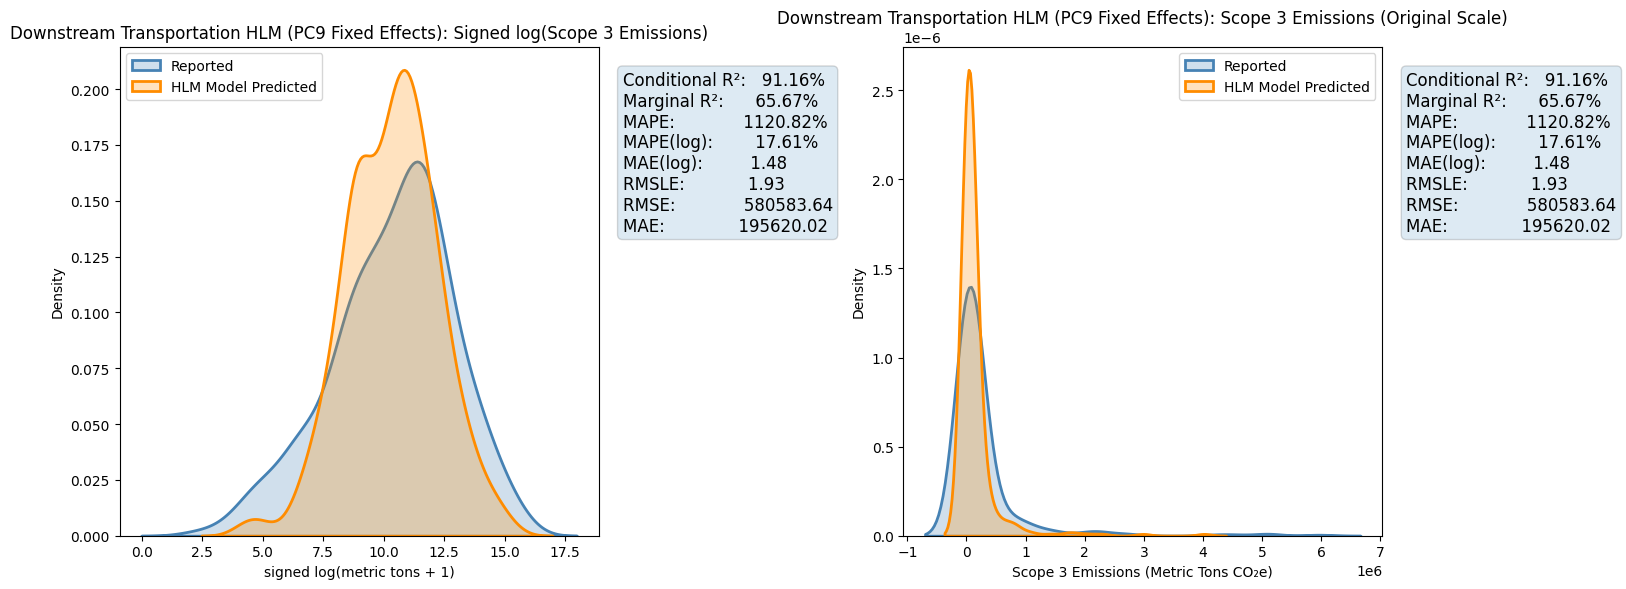

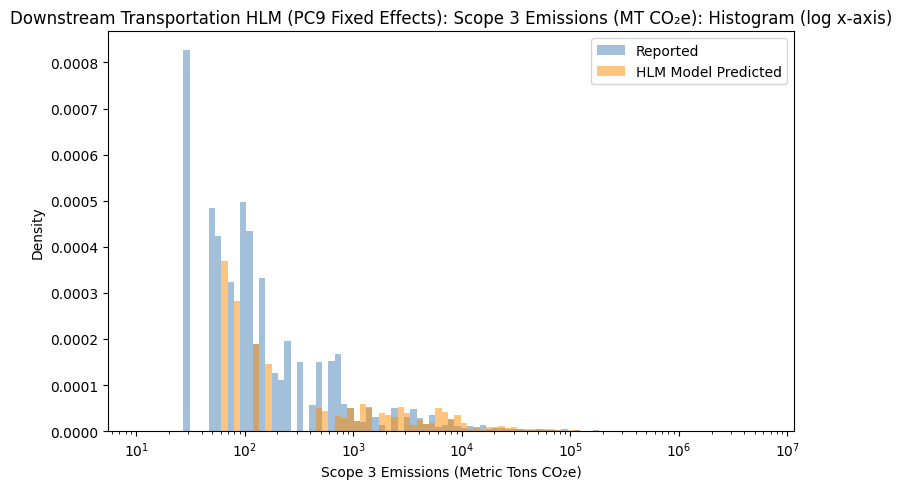

In [10]:
# --- Downstream Transportation PC9 HLM (using new train/test splits) ---

# Assumes train_df and test_df are created as in previous blocks
feature_cols_PC9 = [f'PC9_{i}' for i in range(1, 10)]  # PC9_1 to PC9_9
target_col_PC9 = 'slog_Scope_3_emissions_amount'
cat_cols_PC9 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC9 = feature_cols_PC9 + [target_col_PC9] + cat_cols_PC9
train_df_PC9 = train_df.dropna(subset=all_model_vars_PC9).copy()
test_df_PC9 = test_df.dropna(subset=all_model_vars_PC9).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC9[cat_col].unique())
    n_before = len(test_df_PC9)
    test_df_PC9 = test_df_PC9[test_df_PC9[cat_col].isin(train_cats)]
    n_after = len(test_df_PC9)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC9.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_PC9) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC9} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC9, groups=train_df_PC9['account_id'])
        mdf_PC9 = md.fit(reml=False)
    print(mdf_PC9.summary())

    # --- Calculate Conditional and Marginal R² ---
    var_fixed = np.var(mdf_PC9.fittedvalues)
    var_resid = mdf_PC9.scale
    var_random = mdf_PC9.cov_re.iloc[0, 0] if mdf_PC9.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_PC9['predicted_log'] = mdf_PC9.predict(test_df_PC9)
    test_df_PC9['predicted'] = np.sign(test_df_PC9['predicted_log']) * (np.expm1(np.abs(test_df_PC9['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_PC9[target_col_PC9]
    y_pred_log = test_df_PC9['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC9['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Transportation HLM with PC9 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC9.params,
        'pvalue': mdf_PC9.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Transportation HLM (PC9 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Transportation HLM (PC9 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Transportation HLM (PC9 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Return metrics for summary table ---
    PC9_model_metrics = {
        "Model": "HLM PC9",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC9),
        "# Obs (test)": len(test_df_PC9),
        "# Obs (train/test)": f"{len(train_df_PC9)}/{len(test_df_PC9)}"
    }

### Downstream Transportation: HLM Model with 7 Principal Components

- Uses the newly created `train_df` (years 2018–2022) and `test_df` (year 2023) containing PC7 features.
- Model predictors: seven principal components (`PC7_1`–`PC7_7`), country, activity, and year.
- Drops incomplete rows and ensures all categorical levels in test are present in training.
- Fits a mixed-effects model grouped by company (`account_id`), computes marginal and conditional R², and evaluates predictions with standard metrics (MAPE, MAE, RMSE, RMSLE, etc.).
- Visualizes prediction results and feature coefficients.
- Returns metrics for summary tables.

_Result:_  
A hierarchical linear model using seven PC features for downstream transport, evaluated on a company-level train/test split.

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 1630                  Method:                           ML                           
No. Groups:                       434                   Scale:                            0.7855                       
Min. group size:                  1                     Log-Likelihood:                   -2632.6152                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  3.8                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

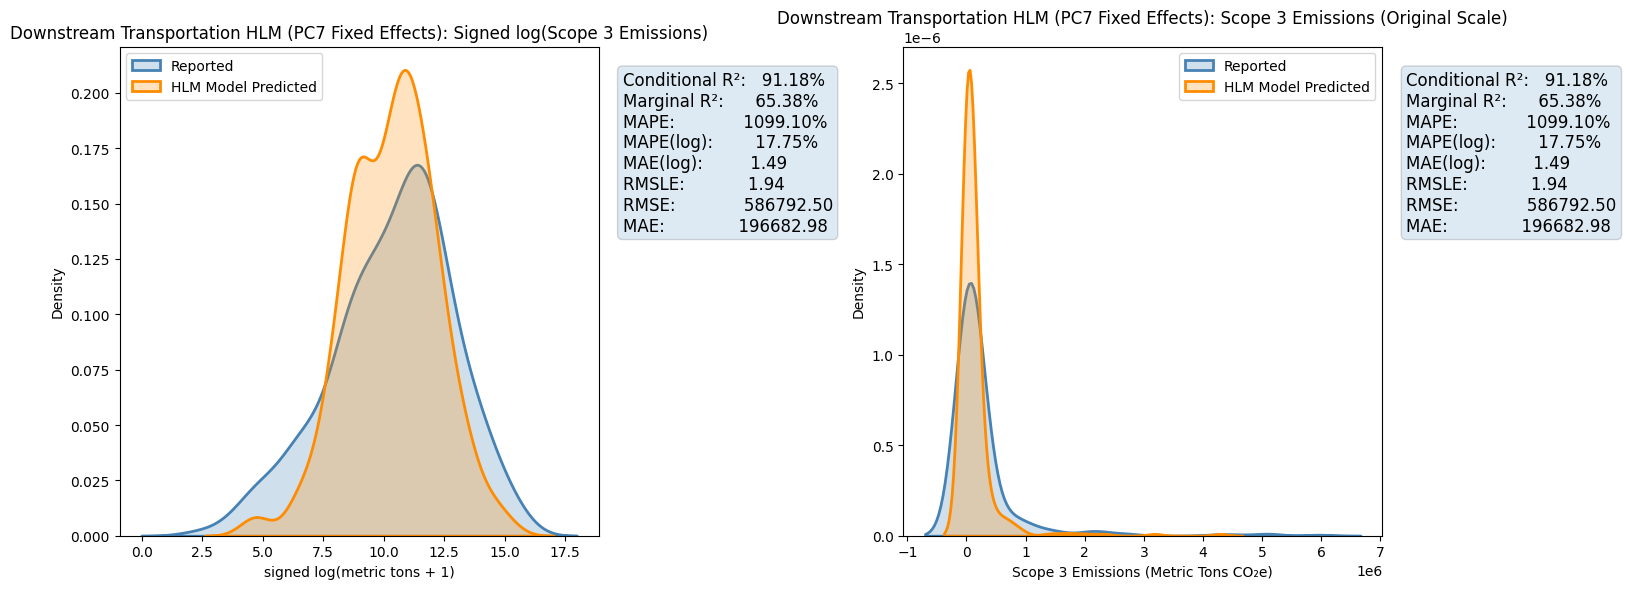

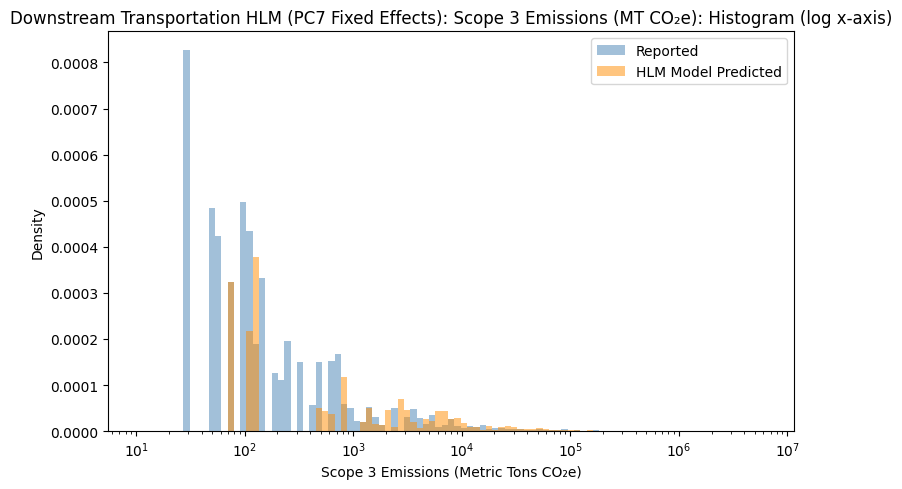

In [11]:
# --- Downstream Transportation PC7 HLM (using new train/test splits) ---

feature_cols_PC7 = [f'PC7_{i}' for i in range(1, 8)]  # PC7_1 to PC7_7
target_col_PC7 = 'slog_Scope_3_emissions_amount'
cat_cols_PC7 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC7 = feature_cols_PC7 + [target_col_PC7] + cat_cols_PC7
train_df_PC7 = train_df.dropna(subset=all_model_vars_PC7).copy()
test_df_PC7 = test_df.dropna(subset=all_model_vars_PC7).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC7[cat_col].unique())
    n_before = len(test_df_PC7)
    test_df_PC7 = test_df_PC7[test_df_PC7[cat_col].isin(train_cats)]
    n_after = len(test_df_PC7)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC7.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_PC7) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC7} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC7, groups=train_df_PC7['account_id'])
        mdf_PC7 = md.fit(reml=False)
    print(mdf_PC7.summary())

    # --- Calculate Conditional and Marginal R² ---
    var_fixed = np.var(mdf_PC7.fittedvalues)
    var_resid = mdf_PC7.scale
    var_random = mdf_PC7.cov_re.iloc[0, 0] if mdf_PC7.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_PC7['predicted_log'] = mdf_PC7.predict(test_df_PC7)
    test_df_PC7['predicted'] = np.sign(test_df_PC7['predicted_log']) * (np.expm1(np.abs(test_df_PC7['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_PC7[target_col_PC7]
    y_pred_log = test_df_PC7['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC7['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Transportation HLM with PC7 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC7.params,
        'pvalue': mdf_PC7.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Transportation HLM (PC7 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Transportation HLM (PC7 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Transportation HLM (PC7 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Return metrics for summary table ---
    PC7_model_metrics = {
        "Model": "HLM PC7",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC7),
        "# Obs (test)": len(test_df_PC7),
        "# Obs (train/test)": f"{len(train_df_PC7)}/{len(test_df_PC7)}"
    }

### Downstream Transportation: HLM Model with 4 Principal Components

- Uses newly created `train_df` (years 2018–2022) and `test_df` (year 2023), filtered for shared companies and complete features.
- Model predictors: four principal components (`PC4_1`–`PC4_4`), country, activity, and year.
- Drops incomplete rows and ensures all categorical levels in test are present in training.
- Fits a mixed-effects model grouped by company (`account_id`), computes marginal and conditional R², and evaluates predictions with standard metrics (MAPE, MAE, RMSE, RMSLE, etc.).
- Visualizes prediction results and feature coefficients.
- Returns metrics for summary tables.

_Result:_  
A robust HLM using four PC features for downstream transport, evaluated on a company-level train/test split.

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 1630                  Method:                           ML                           
No. Groups:                       434                   Scale:                            0.7871                       
Min. group size:                  1                     Log-Likelihood:                   -2641.3463                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  3.8                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

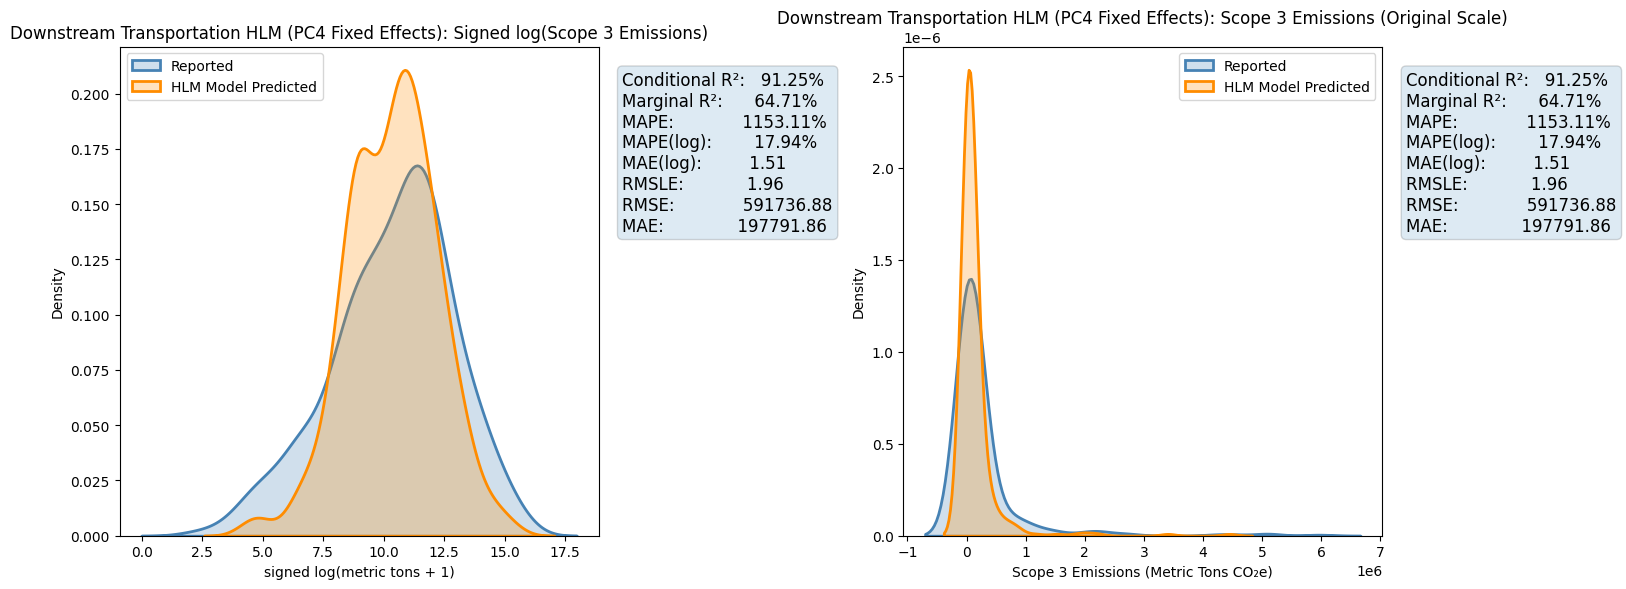

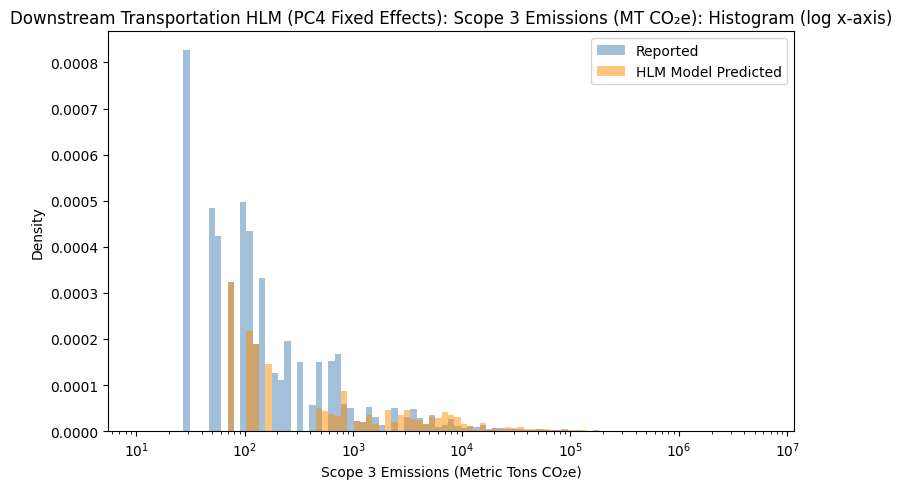

In [12]:
# --- Downstream Transportation PC4 HLM (using new train/test splits) ---

feature_cols_pc4 = [f'PC4_{i}' for i in range(1, 5)]  # PC4_1 to PC4_4
target_col_pc4 = 'slog_Scope_3_emissions_amount'
cat_cols_pc4 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_pc4 = feature_cols_pc4 + [target_col_pc4] + cat_cols_pc4
train_df_pc4 = train_df.dropna(subset=all_model_vars_pc4).copy()
test_df_pc4 = test_df.dropna(subset=all_model_vars_pc4).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_pc4[cat_col].unique())
    n_before = len(test_df_pc4)
    test_df_pc4 = test_df_pc4[test_df_pc4[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_pc4) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_pc4} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    import statsmodels.formula.api as smf
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_pc4, groups=train_df_pc4['account_id'])
        mdf_pc4 = md.fit(reml=False)
    print(mdf_pc4.summary())

    # --- Calculate Conditional and Marginal R² ---
    var_fixed = np.var(mdf_pc4.fittedvalues)
    var_resid = mdf_pc4.scale
    var_random = mdf_pc4.cov_re.iloc[0, 0] if mdf_pc4.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_pc4['predicted_log'] = mdf_pc4.predict(test_df_pc4)
    test_df_pc4['predicted'] = np.sign(test_df_pc4['predicted_log']) * (np.expm1(np.abs(test_df_pc4['predicted_log'])))

    # --- Metrics ---
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
    y_true_log = test_df_pc4[target_col_pc4]
    y_pred_log = test_df_pc4['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Transportation HLM with PC4 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4.params,
        'pvalue': mdf_pc4.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Transportation HLM (PC4 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Transportation HLM (PC4 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Transportation HLM (PC4 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Return metrics for summary table ---
    pc4_model_metrics = {
        "Model": "HLM PC4",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4),
        "# Obs (test)": len(test_df_pc4),
        "# Obs (train/test)": f"{len(train_df_pc4)}/{len(test_df_pc4)}"
    }

Now I'll look into hierarchical clustering on PC4 features to determine if that may add value to increasing prediction accuracy.

### Downstream Transport: Hierarchical Clustering on PC4 Features

- Performs hierarchical clustering (Ward linkage) on the four PC4 principal components using all available valid rows.
- Determines the optimal number of clusters by maximizing the silhouette score across cluster counts (2–30).
- Assigns optimal cluster labels and appends them as a new `Cluster` feature to the original data.
- Plots silhouette scores and the clustering dendrogram for interpretability.
- Appends the resulting `Cluster` feature to both `train_df` and `test_df` for use in future modeling and analysis.

_Result:_  
`train_df` and `test_df` now include a `Cluster` column derived from hierarchical clustering on PC4 features.

Optimal number of clusters (highest silhouette score): 3


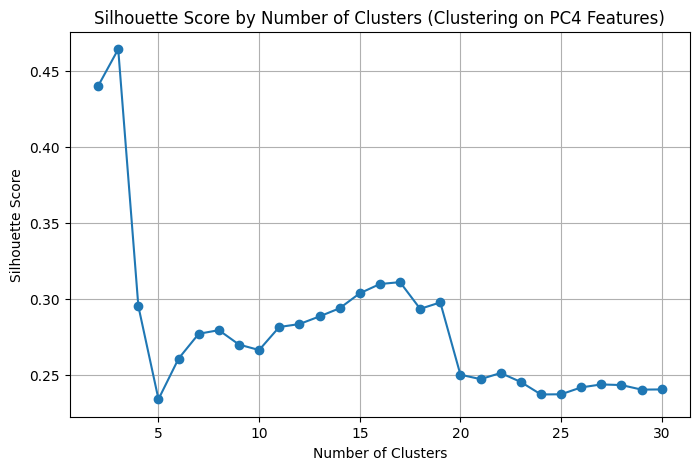

Number of observations in each cluster:
3    1765
1     178
2      31
Name: count, dtype: int64


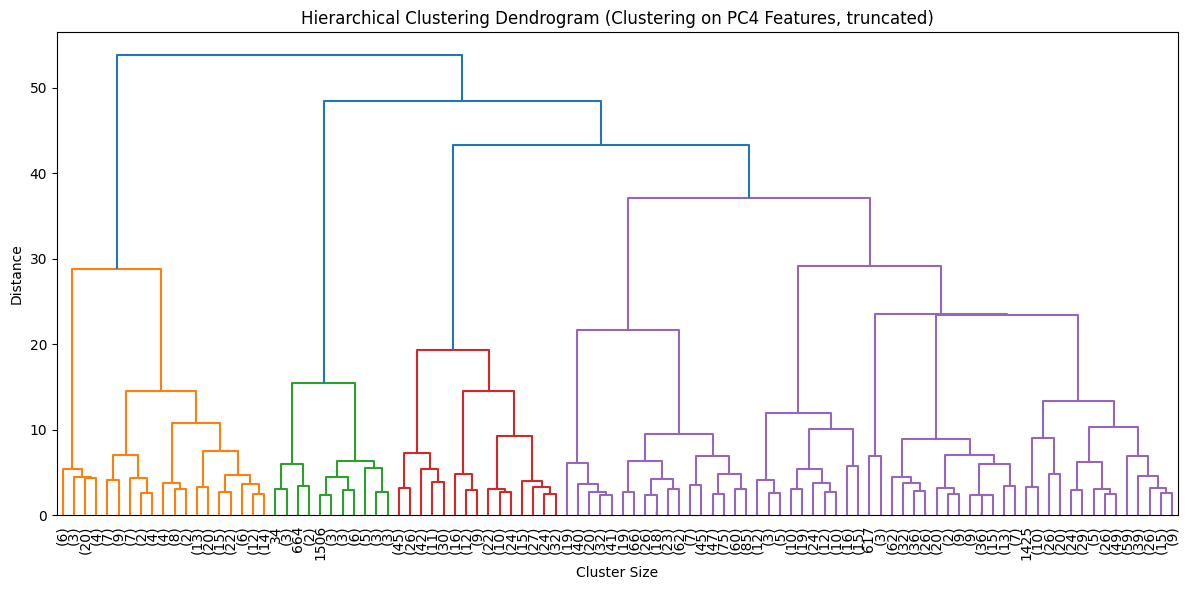

Training set clusters: Cluster
3.0    1449
NaN     408
1.0     159
2.0      22
Name: count, dtype: int64
Test set clusters: Cluster
3.0    294
NaN     94
1.0     17
2.0      9
Name: count, dtype: int64


In [13]:
# --- STEP 1: Select PC4 PCA components for clustering ---
pc4_cols = [f'PC4_{i}' for i in range(1, 5)]
X_pc4 = downstream_transport_pca[pc4_cols].dropna()
clust_indices = X_pc4.index

# --- STEP 2: Standardize the PC4 data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pc4)

# --- STEP 3: Hierarchical clustering (Ward linkage) ---
Z = linkage(X_scaled, method='ward')

# --- STEP 4: Find optimal number of clusters using silhouette score ---
range_n_clusters = range(2, 31)  # 2 to 30 clusters
sil_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"Optimal number of clusters (highest silhouette score): {optimal_n_clusters}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (Clustering on PC4 Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# --- STEP 5: Assign optimal cluster labels ---
labels_optimal = fcluster(Z, optimal_n_clusters, criterion='maxclust')

# --- STEP 6: Append cluster labels back to original DataFrame (only for valid rows) ---
downstream_transport_pca_clusters = downstream_transport_pca.copy()
downstream_transport_pca_clusters['Cluster'] = np.nan  # initialize with NaN
downstream_transport_pca_clusters.loc[clust_indices, 'Cluster'] = labels_optimal

# --- Print cluster counts ---
print("Number of observations in each cluster:")
print(pd.Series(labels_optimal).value_counts())

# --- Optionally plot dendrogram (subset for readability) ---
plt.figure(figsize=(12, 6))
sample_size = min(100, len(X_scaled))  # Plot up to 100 samples for clarity
dendrogram(Z, truncate_mode='lastp', p=sample_size, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Clustering on PC4 Features, truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# --- STEP 7: Append Cluster feature to train_df and test_df for future modeling ---
# Assumes train_df and test_df have the same indices as downstream_transport_pca_clusters for valid rows

if 'Cluster' not in train_df.columns:
    train_df['Cluster'] = downstream_transport_pca_clusters.loc[train_df.index, 'Cluster']
if 'Cluster' not in test_df.columns:
    test_df['Cluster'] = downstream_transport_pca_clusters.loc[test_df.index, 'Cluster']

print("Training set clusters:", train_df['Cluster'].value_counts(dropna=False))
print("Test set clusters:", test_df['Cluster'].value_counts(dropna=False))

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2038 entries, 0 to 2037
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   2038 non-null   object 
 1   account_id                     2038 non-null   int64  
 2   Year                           2038 non-null   int64  
 3   Countries                      2038 non-null   object 
 4   Primary_activity               2038 non-null   object 
 5   Primary_sector                 2038 non-null   object 
 6   Market_Cap_USD                 1637 non-null   float64
 7   Revenue_USD                    1666 non-null   float64
 8   ebitda_USD                     1666 non-null   float64
 9   grossProfit_USD                1666 non-null   float64
 10  netIncome_USD                  1666 non-null   float64
 11  cashAndCashEquivalents_USD     1666 non-null   float64
 12  shortTermInvestments_USD       1666 non-null   float6

### Downstream Transportation: HLM Model with PC4 and Cluster Features

- Uses `train_df` (years 2018–2022) and `test_df` (year 2023) with appended `Cluster` labels from hierarchical clustering and PC4 principal components.
- Model predictors: four principal components (`PC4_1`–`PC4_4`), `Cluster`, country, activity, and year.
- Drops incomplete rows and ensures all categorical levels in test are present in training, including clusters.
- Fits a mixed-effects model grouped by company (`account_id`), computes marginal and conditional R², and evaluates predictions with standard metrics (MAPE, MAE, RMSE, RMSLE, etc.).
- Visualizes prediction results and feature coefficients.
- Returns metrics for summary tables.

_Result:_  
A robust HLM using PC4 principal components and cluster membership for downstream transport, evaluated on a company-level train/test split.

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 1630                  Method:                           ML                           
No. Groups:                       434                   Scale:                            0.7870                       
Min. group size:                  1                     Log-Likelihood:                   -2641.0807                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  3.8                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

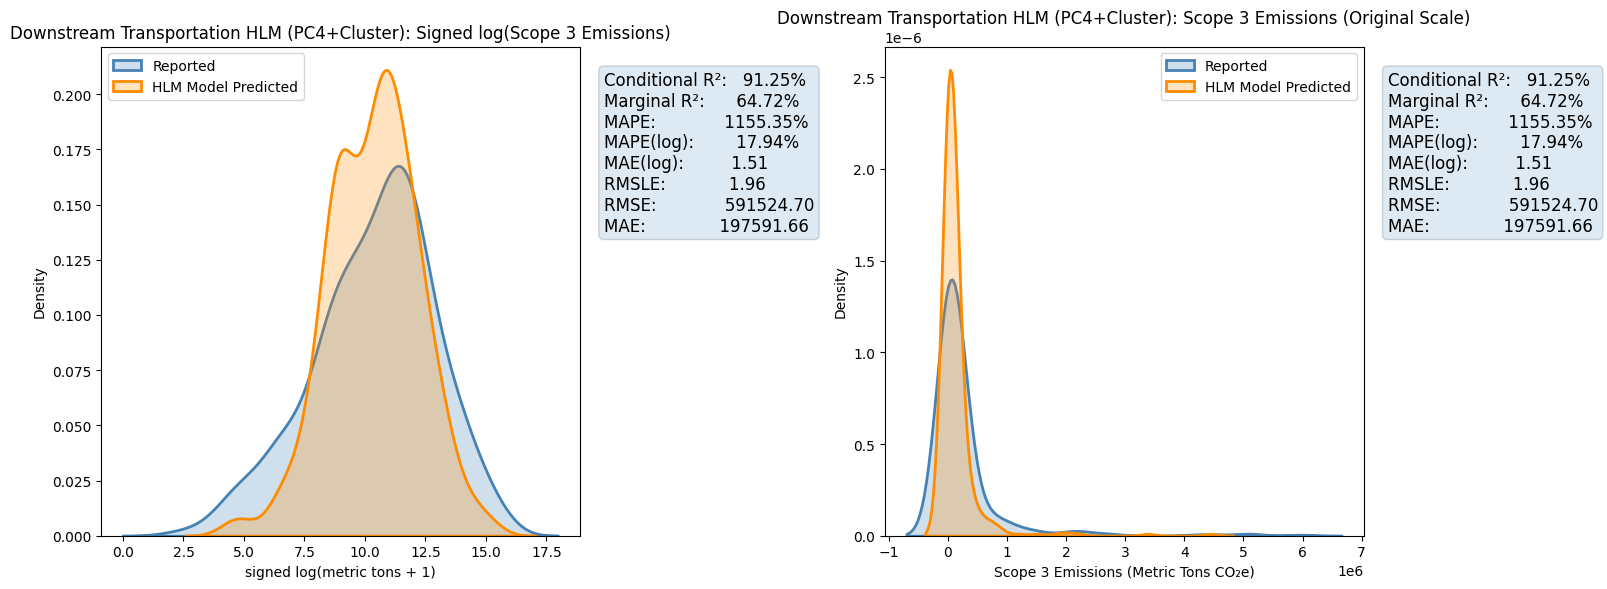

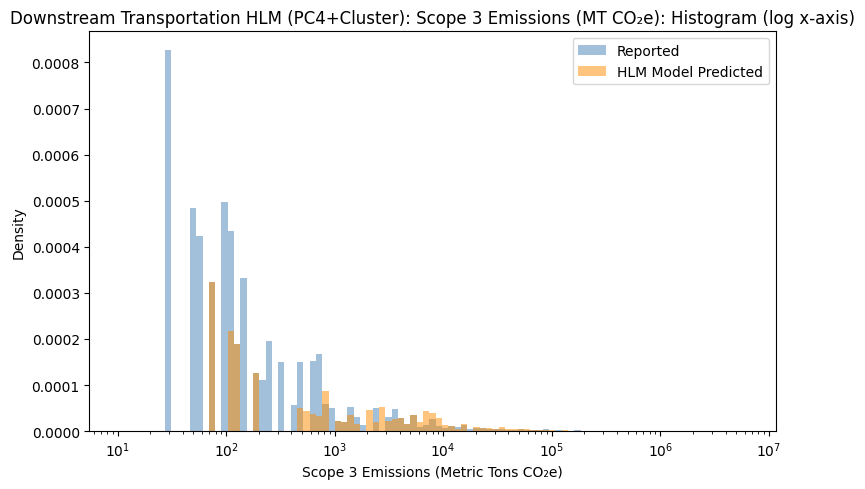

In [15]:
# --- Downstream Transportation PC4 + Cluster HLM (using train_df and test_df with 'Cluster' feature) ---

feature_cols_pc4_cluster = [f'PC4_{i}' for i in range(1, 5)] + ['Cluster']
target_col = 'slog_Scope_3_emissions_amount'
cat_cols = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars = feature_cols_pc4_cluster + [target_col] + cat_cols

# --- Prepare Data ---
train_df_pc4c = train_df.dropna(subset=all_model_vars).copy()
test_df_pc4c = test_df.dropna(subset=all_model_vars).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity', 'Cluster']:
    train_cats = set(train_df_pc4c[cat_col].unique())
    n_before = len(test_df_pc4c)
    test_df_pc4c = test_df_pc4c[test_df_pc4c[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4c)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4c.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join([f'C({col})' if col == 'Cluster' else col for col in feature_cols_pc4_cluster]) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    import statsmodels.formula.api as smf
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_pc4c, groups=train_df_pc4c['account_id'])
        mdf_pc4c = md.fit(reml=False)
    print(mdf_pc4c.summary())

    # --- Calculate Conditional and Marginal R² ---
    var_fixed = np.var(mdf_pc4c.fittedvalues)
    var_resid = mdf_pc4c.scale
    var_random = mdf_pc4c.cov_re.iloc[0, 0] if mdf_pc4c.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_pc4c['predicted_log'] = mdf_pc4c.predict(test_df_pc4c)
    test_df_pc4c['predicted'] = np.sign(test_df_pc4c['predicted_log']) * (np.expm1(np.abs(test_df_pc4c['predicted_log'])))

    # --- Metrics ---
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
    y_true_log = test_df_pc4c[target_col]
    y_pred_log = test_df_pc4c['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4c['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nDownstream Transportation HLM with PC4+Cluster Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4c.params,
        'pvalue': mdf_pc4c.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Downstream Transportation HLM (PC4+Cluster): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Downstream Transportation HLM (PC4+Cluster): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Downstream Transportation HLM (PC4+Cluster): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Return metrics for summary table ---
    pc4_cluster_model_metrics = {
        "Model": "HLM PC4+Cluster",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4c),
        "# Obs (test)": len(test_df_pc4c),
        "# Obs (train/test)": f"{len(train_df_pc4c)}/{len(test_df_pc4c)}"
    }

## Metrics Table

In [16]:
# Collect metrics dicts from each model; change names as needed
metrics_dicts = [
    PC9_model_metrics,         # "HLM PC9"
    PC7_model_metrics,         # "HLM PC7"
    pc4_model_metrics,         # "HLM PC4"
    pc4_cluster_model_metrics  # "HLM PC4+Cluster"
]

# Attach observation counts, convergence status, and explained variance to each dictionary
for metrics, train, test, fit_result, explained_var in zip(
        metrics_dicts,
        [train_df_PC9, train_df_PC7, train_df_pc4, train_df_pc4c],
        [test_df_PC9, test_df_PC7, test_df_pc4, test_df_pc4c],
        [mdf_PC9, mdf_PC7, mdf_pc4, mdf_pc4c],
        [
            sum(pca9.explained_variance_ratio_),
            sum(pca7.explained_variance_ratio_),
            sum(pca4.explained_variance_ratio_),
            sum(pca4.explained_variance_ratio_)
        ]):
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"
    metrics["Converged"] = "Yes" if getattr(fit_result, "converged", False) else "No"
    metrics["PC Explained Variance"] = explained_var

# Add a new row for your "Optimized" model
optimized_row = {
    "Model": "Optimized Downstream Transportation HLM",
    "Conditional_R2": 0.9113,   # as a fraction, not percent
    "Marginal_R2": 0.6552,
    "RMSE": 612898.23,
    "MAE": 207195.09,
    "MAE_log": 1.45,
    "RMSLE": 1.91,
    "MAPE": 1219.34,
    "# Obs (train/test)": "1630/303",
    "PC Explained Variance": np.nan,
    "Converged": "Yes"
}
metrics_dicts.append(optimized_row)

metrics_df = pd.DataFrame(metrics_dicts)

# Order columns for summary (Converged LAST)
desired_order = [
    "Model", "PC Explained Variance", "Conditional_R2", "Marginal_R2", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)", "Converged"
]

# Add MAE_log if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

# Format for display
metrics_df_display = metrics_df.copy()
if "Conditional_R2" in metrics_df_display.columns:
    metrics_df_display["Conditional_R2"] = (metrics_df_display["Conditional_R2"].astype(float) * 100).map("{:.2f}%".format)
if "Marginal_R2" in metrics_df_display.columns:
    metrics_df_display["Marginal_R2"] = (metrics_df_display["Marginal_R2"].astype(float) * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "PC Explained Variance"]:
    if col in metrics_df_display.columns:
        if col == "PC Explained Variance":
            metrics_df_display[col] = metrics_df_display[col].apply(lambda v: "{:.2%}".format(v) if pd.notnull(v) else "")
        else:
            metrics_df_display[col] = metrics_df_display[col].astype(float).map("{:.2f}".format)

# Display in notebook or print
try:
    display(metrics_df_display)
except Exception:
    print(metrics_df_display.to_string(index=False))

,Model,PC Explained Variance,Conditional_R2,Marginal_R2,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test),Converged
0,HLM PC9,90.78%,91.16%,65.67%,580583.64,195620.02,1.48,1.93,1120.82,1630/312,Yes
1,HLM PC7,83.39%,91.18%,65.38%,586792.50,196682.98,1.49,1.94,1099.10,1630/312,Yes
2,HLM PC4,65.79%,91.25%,64.71%,591736.88,197791.86,1.51,1.96,1153.11,1630/312,Yes
3,HLM PC4+Cluster,65.79%,91.25%,64.72%,591524.70,197591.66,1.51,1.96,1155.35,1630/312,Yes
4,Optimized Downstream Transportation HLM,,91.13%,65.52%,612898.23,207195.09,1.45,1.91,1219.34,1630/303,Yes
